In [1]:
%matplotlib inline

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
import json
from matplotlib import patches
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image, ImageDraw
import numpy as np
from pathlib import Path
import os
from torch_lr_finder import LRFinder, TrainDataLoaderIter
from datetime import datetime
import time
import timm

c:\Users\zack\anaconda3\envs\bohb_pt\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### <center> Load Images and Annotations </center>

In [2]:
def process_coco_annotations(anno_file):
    annos = json.load(open(anno_file))
    annos_df = pd.DataFrame(annos["annotations"])
    df = pd.DataFrame()

    # Extract base name from json file 
    base_name = Path(anno_file).name.split('_annotations.coco.json')[0]

    df["tree_id"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"].split("_")[0])
    df["file_name"] = annos_df["image_id"].apply(lambda x: f"{base_name}_{annos['images'][x]['file_name'].split('_')[0]}.jpg")
    categories = [cat["name"] for cat in annos["categories"]]
    df["category_name"] = annos_df["category_id"].apply(lambda x: categories[x])
    df["bbox"] = annos_df["bbox"].apply(lambda x: torch.tensor(x))
    df["area"] = annos_df["area"].apply(lambda x: torch.tensor(x))
    df["segmentation"] = annos_df["segmentation"].apply(lambda x: torch.tensor(x))
    df["iscrowd"] = annos_df["iscrowd"]
    return df

# List of annotation files
annotation_files = [
    "S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3_annotations.coco.json",
    "S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard4_annotations.coco.json"
]

# Process and concatenate all files
df = pd.concat([process_coco_annotations(file) for file in annotation_files], ignore_index=True)

# Before processing files, standardize category names
df['category_name'] = df['category_name'].replace({
    'canopy': 'Canopy',
    'chestnut bur': 'Chestnut-burr'
})

# filter df to only include reviewed images
reviewed_dir = Path('S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/reviewed_images')
existing_files = set(f.name for f in reviewed_dir.iterdir() if f.is_file())
df = df[df["file_name"].isin(existing_files)]

# Get unique image names
image_names = df["file_name"].unique()

#### <center> Image Pre-processing </center>

In [3]:
# def create_polygon_mask(mask, polys, color):
#     for poly in polys:
#         poly_mask = Image.new("L", (mask.shape[1], mask.shape[0]), 0)
#         ImageDraw.Draw(poly_mask).polygon(poly, fill=color)
#         poly_mask = np.array(poly_mask)
#         mask = np.maximum(mask, poly_mask)
#     return mask

# def transform_bbox_to_tile_coords(bbox, tile_left, tile_top, global_left, global_top, tile_width, tile_height):
#     x, y, w, h = bbox
#     x_padded = x - global_left
#     y_padded = y - global_top
#     x_in_tile = x_padded - tile_left
#     y_in_tile = y_padded - tile_top
#     x2_in_tile = x_in_tile + w
#     y2_in_tile = y_in_tile + h
#     x_clamped = max(0, min(tile_width, x_in_tile))
#     y_clamped = max(0, min(tile_height, y_in_tile))
#     x2_clamped = max(0, min(tile_width, x2_in_tile))
#     y2_clamped = max(0, min(tile_height, y2_in_tile))
#     clipped_w = x2_clamped - x_clamped
#     clipped_h = y2_clamped - y_clamped
#     if clipped_w <= 0 or clipped_h <= 0:
#         return None
#     return (x_clamped, y_clamped, clipped_w, clipped_h)

# # Define output directories
# base_output_dir = Path('S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net')
# preprocessed_image_dir = base_output_dir / 'images'
# mask_output_dir = base_output_dir / 'masks'
# png_output_dir = base_output_dir / 'PNGs'

# preprocessed_image_dir.mkdir(parents=True, exist_ok=True)
# mask_output_dir.mkdir(parents=True, exist_ok=True)
# png_output_dir.mkdir(parents=True, exist_ok=True)

# image_dir = 'S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/reviewed_images'
# preprocessed_data = []

# tile_height, tile_width = 224, 224
# overlap_pct = 0.20
# stride_y = int(tile_height * (1 - overlap_pct))
# stride_x = int(tile_width * (1 - overlap_pct))

# for file_name in df["file_name"].unique():
#     try:
#         print(f"Processing file: {file_name}")
#         row = df[df["file_name"] == file_name]
#         image_path = Path(image_dir) / row["file_name"].values[0]
#         image = Image.open(image_path).convert('RGB')
#         image_np = np.array(image)

#         canopy_poly = row[row["category_name"] == "Canopy"]["segmentation"].values
#         canopy_poly = [np.array(poly[0]).reshape(-1, 2).tolist() for poly in canopy_poly]
#         canopy_poly = [[tuple(p) for p in poly] for poly in canopy_poly]
#         canopy_mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
#         canopy_mask = create_polygon_mask(canopy_mask, canopy_poly, 1)

#         bur_poly = row[row["category_name"] == "Chestnut-burr"]["segmentation"].values
#         bur_poly = [np.array(poly[0]).reshape(-1, 2).tolist() for poly in bur_poly]
#         bur_poly = [[tuple(p) for p in poly] for poly in bur_poly]
#         bur_masks = []
#         for poly in bur_poly:
#             mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
#             mask = create_polygon_mask(mask, [poly], 1)
#             bur_masks.append(mask)
#         mask_image = np.stack(bur_masks, axis=0)
#         mask_image = mask_image.transpose(1, 2, 0)

#         canopy_bbox = row[row["category_name"] == "Canopy"]["bbox"].values[0]
#         padding = 50.0
#         padded_bbox = [
#             max(0, int(canopy_bbox[0] - padding)),
#             max(0, int(canopy_bbox[1] - padding)),
#             min(image_np.shape[1], int(canopy_bbox[0] + canopy_bbox[2] + padding)),
#             min(image_np.shape[0], int(canopy_bbox[1] + canopy_bbox[3] + padding))
#         ]
#         image_cropped = image_np[padded_bbox[1]:padded_bbox[3], padded_bbox[0]:padded_bbox[2]]
#         mask_cropped = mask_image[padded_bbox[1]:padded_bbox[3], padded_bbox[0]:padded_bbox[2], :]

#         canopy_mask_cropped = canopy_mask[padded_bbox[1]:padded_bbox[3], padded_bbox[0]:padded_bbox[2]].astype(bool)
#         fill_color = [0, 0, 0]
#         for c in range(3):
#             image_cropped[..., c][~canopy_mask_cropped] = fill_color[c]

#         image_height, image_width, _ = image_cropped.shape
#         padded_height = ((image_height + tile_height - 1) // tile_height) * tile_height
#         padded_width = ((image_width + tile_width - 1) // tile_width) * tile_width

#         padded_image = np.zeros((padded_height, padded_width, 3), dtype=np.float32)
#         padded_image[:image_height, :image_width, :] = image_cropped

#         padded_mask = np.zeros((padded_height, padded_width, mask_cropped.shape[2]), dtype=np.uint8)
#         padded_mask[:image_height, :image_width, :] = mask_cropped

#         for tile_y in range(0, padded_height - tile_height + 1, stride_y):
#             for tile_x in range(0, padded_width - tile_width + 1, stride_x):
#                 tile_image = padded_image[tile_y:tile_y+tile_height, tile_x:tile_x+tile_width, :]
#                 tile_mask = padded_mask[tile_y:tile_y+tile_height, tile_x:tile_x+tile_width, :]
#                 if np.all(tile_image == 0):
#                     continue

#                 tile_bboxes = []
#                 tile_masks = []
#                 tile_polys = []  # store polygon coordinates for drawing

#                 bur_rows = row[row["category_name"] == "Chestnut-burr"]
#                 for bbox_arr, mask_arr in zip(bur_rows["bbox"].values, bur_rows["segmentation"].values):
#                     tile_bbox = transform_bbox_to_tile_coords(
#                         bbox_arr,
#                         tile_x, tile_y,
#                         padded_bbox[0], padded_bbox[1],
#                         tile_width, tile_height
#                     )
#                     if tile_bbox is None:
#                         continue
#                     bx, by, bw, bh = tile_bbox
#                     tile_bboxes.append({
#                         "tree_id": bur_rows["tree_id"].values[0],
#                         "file_name": f"{Path(file_name).stem}_{tile_y}_{tile_x}",
#                         "bbox_x": float(bx),
#                         "bbox_y": float(by),
#                         "bbox_w": float(bw),
#                         "bbox_h": float(bh),
#                         "category_name": "Chestnut-burr",
#                         "iscrowd": int(bur_rows["iscrowd"].values[0]),
#                         "tile_x": tile_x,
#                         "tile_y": tile_y
#                     })

#                     # Create mask for the bounding box
#                     mask_tile = np.zeros((tile_height, tile_width), dtype=np.uint8)
#                     poly = np.array(mask_arr[0]).reshape(-1, 2).tolist()
#                     poly = [(p[0] - padded_bbox[0] - tile_x, p[1] - padded_bbox[1] - tile_y) for p in poly]
#                     mask_tile = create_polygon_mask(mask_tile, [poly], 1)
#                     tile_masks.append(mask_tile)
#                     tile_polys.append(poly)

#                 if len(tile_bboxes) < 2:
#                     continue

#                 tile_mask = np.stack(tile_masks, axis=2)
#                 tile_image_path = preprocessed_image_dir / f"{Path(file_name).stem}_{tile_y}_{tile_x}.npy"
#                 tile_mask_path = mask_output_dir / f"{Path(file_name).stem}_{tile_y}_{tile_x}.npz"
#                 np.save(tile_image_path, tile_image)
#                 np.savez_compressed(tile_mask_path, tile_mask)
                
#                 # Plot polygons on tile image and save as PNG
#                 tile_image_uint8 = np.uint8(np.clip(tile_image, 0, 255))
#                 tile_pil = Image.fromarray(tile_image_uint8)
#                 draw = ImageDraw.Draw(tile_pil)
#                 for poly in tile_polys:
#                     draw.line(poly + [poly[0]], fill="red", width=1)
#                 png_path = png_output_dir / f"{Path(file_name).stem}_{tile_y}_{tile_x}.png"
#                 tile_pil.save(png_path)

#                 preprocessed_data.extend(tile_bboxes)

#     except Exception as e:
#         print(f"Error processing file {file_name}: {e}")

# preprocessed_df = pd.DataFrame(preprocessed_data)
# updated_csv_path = base_output_dir / 'annotations.csv'
# preprocessed_df.to_csv(updated_csv_path, index=False)

#### <center> PyTorch Dataset </center>

In [4]:
class ChestnutBurSegmentation(Dataset):
    def __init__(self, images_dir, masks_dir, annotations_csv, transform=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.annotations = pd.read_csv(annotations_csv)
        self.transform = transform
        self.file_names = self.annotations["file_name"].unique()

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        file_name = self.file_names[idx]
        image_path = self.images_dir / f'{Path(file_name).stem}.npy'
        mask_path = self.masks_dir / f'{Path(file_name).stem}.npz'

        # Load the preprocessed image and mask
        image = np.load(image_path)
        mask = np.load(mask_path)['arr_0']

        # Convert image and mask to tv_tensors
        image = tv_tensors.Image(torch.tensor(image).permute(2, 0, 1))  # [C, H, W]
        instance_masks = tv_tensors.Mask(torch.tensor(mask).permute(2, 0, 1))  # [N, H, W] where N is instances
        
        # Combine instance masks into binary mask
        binary_mask = torch.max(instance_masks, dim=0)[0].unsqueeze(0)  # [1, H, W]
        binary_mask = tv_tensors.Mask(binary_mask)

        # Get the annotations for the current file
        annotations = self.annotations[self.annotations["file_name"] == file_name]

        labels = [1] * len(annotations)  # All labels are "Chestnut-burr"
        bboxes = annotations[["bbox_x", "bbox_y", "bbox_w", "bbox_h"]].values
        bboxes = [torch.tensor([float(bbox[0]), float(bbox[1]), 
                              float(bbox[0] + bbox[2]), float(bbox[1] + bbox[3])], 
                              dtype=torch.float32) for bbox in bboxes]
        bboxes = torch.stack(bboxes, dim=0)
        iscrowd = annotations["iscrowd"].values
        area = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])

        # Create the target dictionary
        target = {
            "boxes": tv_tensors.BoundingBoxes(bboxes, 
                                            format=tv_tensors.BoundingBoxFormat.XYXY, 
                                            canvas_size=(image.shape[1], image.shape[2])),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": idx,
            "area": area.clone().detach(),
            "iscrowd": torch.tensor(iscrowd, dtype=torch.uint8),
            "masks": binary_mask,  # Use binary mask for SmallObjectUNet
        }

        if self.transform:
            image, target = self.transform(image, target)

        return image, target

    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))

#### <center> Transformation Pipeline </center>

In [5]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.ToImage())
        transforms.append(T.ToDtype(torch.float32, scale=True))
        transforms.extend([
            T.RandomHorizontalFlip(0.5),  
            T.RandomVerticalFlip(0.5),    
            # T.RandomRotation(degrees=(-10, 10)),  
            # T.RandomAffine(
            #     degrees=1,        
            #     translate=(0.05, 0.05), 
            #     scale=(0.95, 1.05),
            #     interpolation=T.InterpolationMode.BILINEAR  
            # ),
            # T.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0),
            # T.RandomApply([
            #     T.GaussianBlur(kernel_size=1, sigma=(0.1, 1.0))
            # ], p=0.2),
        ])
    transforms.append(T.ClampBoundingBoxes())
    # transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return T.Compose(transforms)

#### <center> Plot Sample Batch </center>

In [6]:
images_dir = 'S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/images'
masks_dir = 'S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/masks'
annotations_csv = 'S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/annotations.csv'

sample_ds = ChestnutBurSegmentation(images_dir, 
                                    masks_dir, 
                                    annotations_csv,
                                    transform = get_transform(train=True))

sample_dl = DataLoader(sample_ds, 
                       batch_size = 4, 
                       shuffle = True, 
                       collate_fn = ChestnutBurSegmentation.collate_fn)

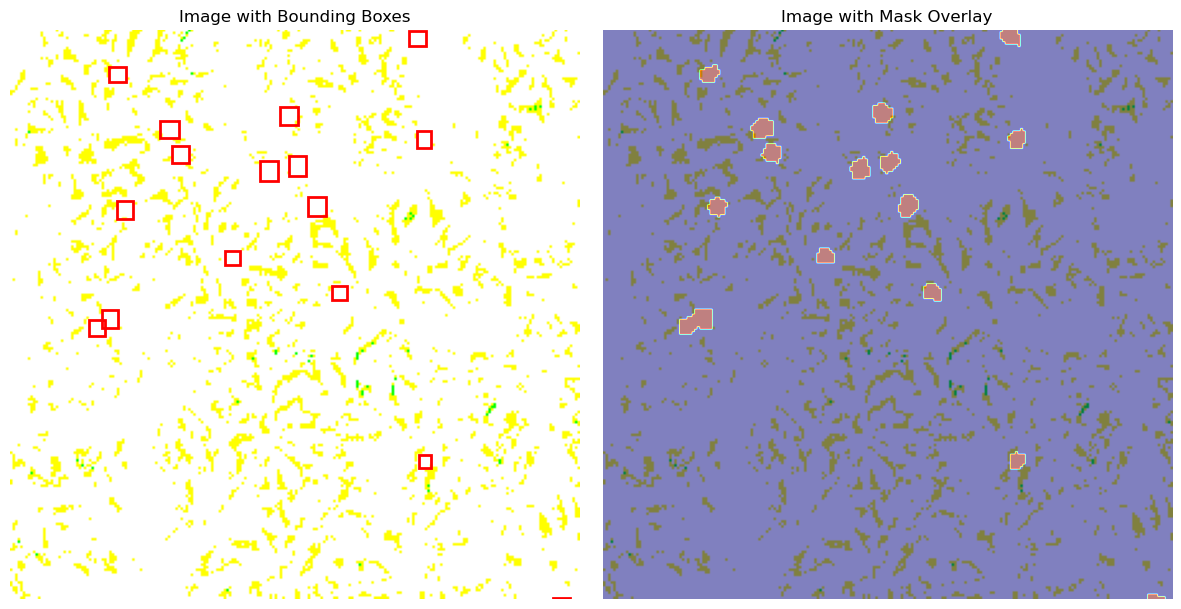

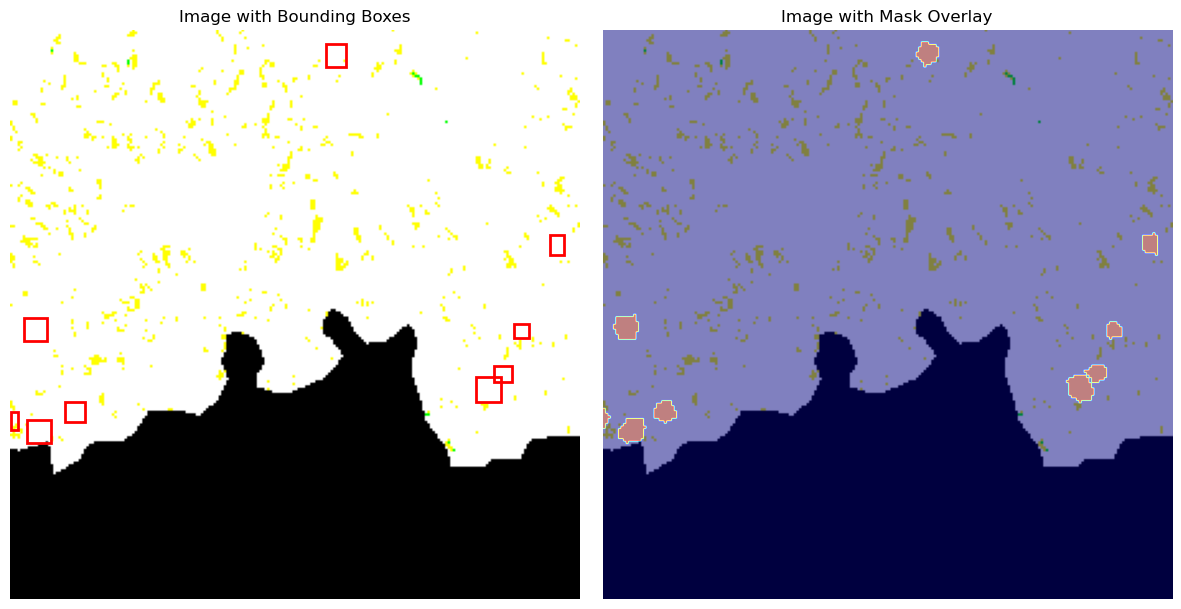

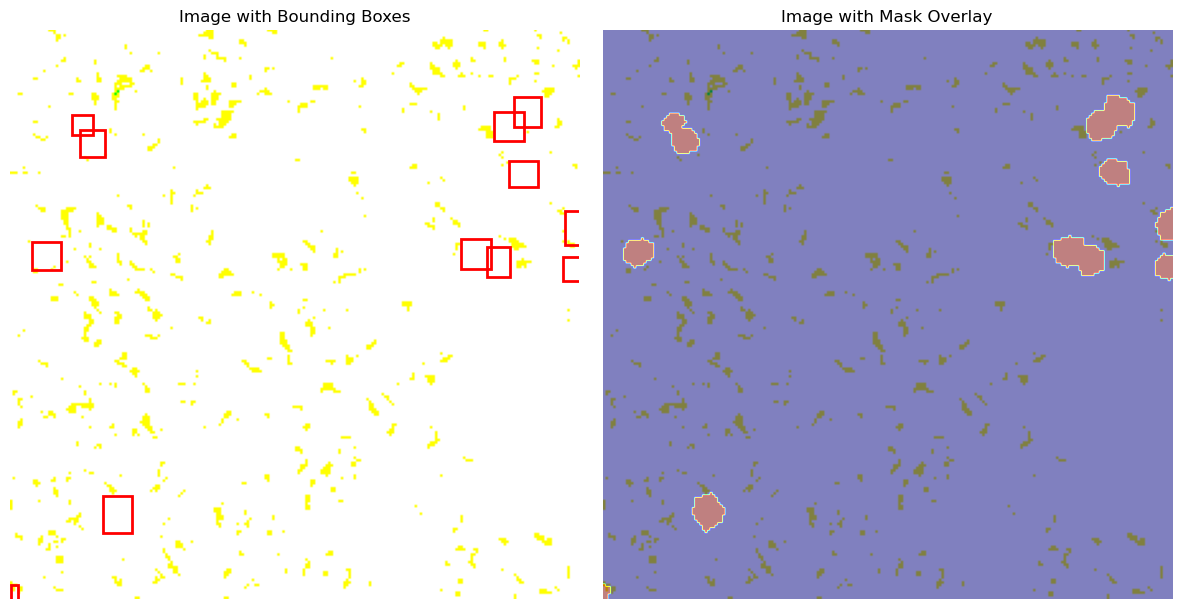

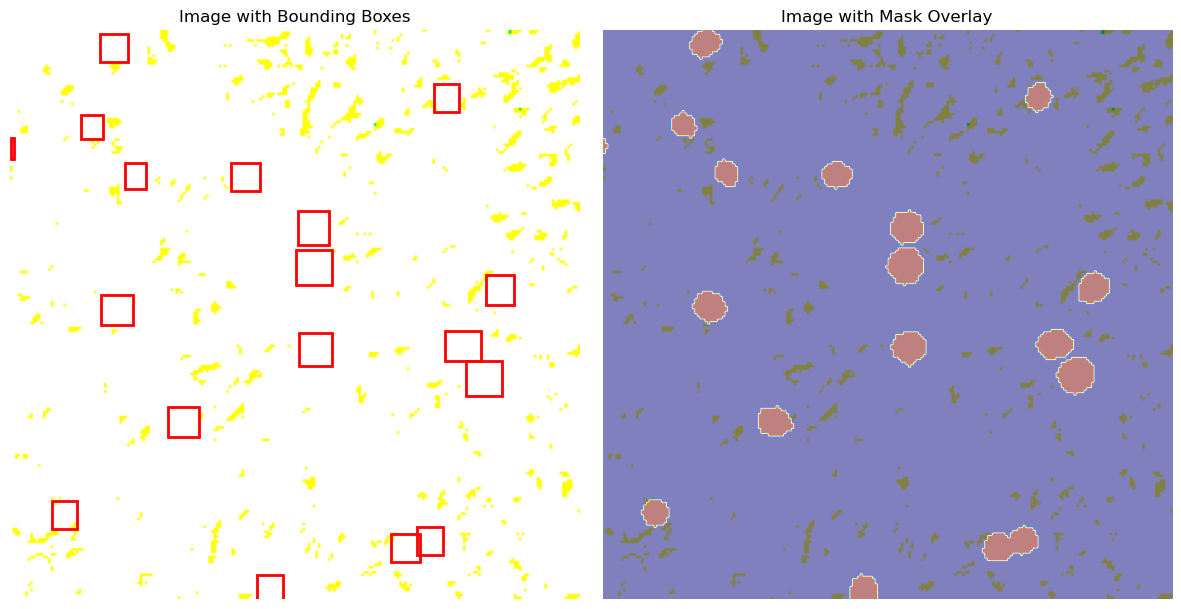

In [7]:
def plot_image_with_annotations(image, target):
    """
    Plot an image with bounding boxes (left) and with an overlayed mask (right).

    Parameters:
      image: tv_tensors.Image wrapping a torch.Tensor of shape [C, H, W]
      target: dictionary with keys "boxes" (BoundingBoxes) and "masks" (Mask)
    """
    # Convert image tensor to numpy image in HxWxC format
    # (Assumes image tensor is already in the proper format, note: normalization is not reversed)
    img_np = image.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    # Extract bounding boxes from target.
    # Depending on your tv_tensors version, access the underlying tensor via .data or .tensor.
    if hasattr(target["boxes"], "data"):
        boxes = target["boxes"].data
    else:
        boxes = target["boxes"].tensor
    boxes = boxes.cpu().numpy()

    # Extract mask from target.
    if hasattr(target["masks"], "data"):
        mask_tensor = target["masks"].data
    else:
        mask_tensor = target["masks"].tensor
    mask_np = mask_tensor.cpu().numpy()  # shape: (C, H, W)
    # Combine channels if necessary (assumes binary masks per instance)
    if mask_np.ndim == 3:
        combined_mask = np.sum(mask_np, axis=0)
    else:
        combined_mask = mask_np

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Left: Plot image with bounding boxes
    ax = axes[0]
    ax.imshow(img_np)
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.set_title("Image with Bounding Boxes")
    ax.axis("off")

    # Right: Plot image with mask overlay
    ax = axes[1]
    ax.imshow(img_np)
    ax.imshow(combined_mask, cmap='jet', alpha=0.5)
    ax.set_title("Image with Mask Overlay")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

images, targets = next(iter(sample_dl))
images = [img for img in images]
targets = [{k: v for k, v in target.items()} for target in targets]

for i in range(len(images)):
    plot_image_with_annotations(images[i], targets[i])

#### <center> Model Definition </center>

In [8]:
# def find_optimal_threshold(pred_probs, target_masks, thresholds=None):
#     """
#     Find optimal threshold based on IoU scores
#     pred_probs: [B, 1, H, W] sigmoid probabilities
#     target_masks: [B, 1, H, W] binary ground truth
#     """
#     if thresholds is None:
#         thresholds = torch.linspace(0.2, 0.9, 15, device=pred_probs.device)
    
#     best_iou = 0
#     best_threshold = 0.5
    
#     for threshold in thresholds:
#         binary_masks = (pred_probs > threshold).float()
#         # Calculate batch IoU
#         intersection = (binary_masks * target_masks).sum((2,3))
#         union = binary_masks.sum((2,3)) + target_masks.sum((2,3)) - intersection
#         iou = (intersection / (union + 1e-6)).mean()
        
#         if iou > best_iou:
#             best_iou = iou
#             best_threshold = threshold
    
#     return best_threshold

def get_norm(num_channels):
    return nn.BatchNorm2d(num_channels)

def calculate_pos_weight(dataset):
    """Calculate positive weight based on class distribution in dataset"""
    total_pixels = 0
    positive_pixels = 0
    
    for i in range(len(dataset)):
        _, target = dataset[i]
        mask = target['masks']
        total_pixels += mask.numel()
        positive_pixels += mask.sum()
    
    neg_pos_ratio = (total_pixels - positive_pixels) / positive_pixels
    return torch.tensor([neg_pos_ratio])

def calculate_confidence(binary_mask, target_mask):
    """Calculate confidence using IoU for semantic segmentation"""
    intersection = (binary_mask * target_mask).sum() # overlapping pixels
    union = binary_mask.sum() + target_mask.sum() - intersection # combined pixels
    confidence = intersection / (union + 1e-6) # IoU
    return confidence

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.0):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            get_norm(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            get_norm(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(x_cat))
        return x * attention

class AttentionDecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, dropout_rate=0.0):
        super(AttentionDecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.spatial_attention = SpatialAttention()
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate) if dropout_rate > 0 else nn.Identity()
        )
        self.adjust_skip = nn.Identity()

    def forward(self, x, skip):
        x = self.up(x)
        skip_att = self.spatial_attention(skip)
        if skip_att.shape[2:] != x.shape[2:]:
            skip_att = F.interpolate(skip_att, size=x.shape[2:], mode='bilinear', align_corners=False)
        skip_att = self.adjust_skip(skip_att)
        x = torch.cat([x, skip_att], dim=1)
        return self.conv(x)

class SmallObjectUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_filters=64, dataset=None,
                 grad_clip=1.0, l2_lambda=0.01, pos_weight=1.0, dice_weight=0.5,
                 deep_supervision=True, dropout_rate=0.5,
                 sup_weights={'sup3_weight': 0.2, 'sup2_weight': 0.15, 'sup1_weight': 0.1}):
        super(SmallObjectUNet, self).__init__()
        self.encoder = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, features_only=True)
        encoder_channels = self.encoder.feature_info.channels()  # [96, 192, 384, 768]
        self.grad_clip = grad_clip
        self.l2_lambda = l2_lambda
        self.dice_weight = dice_weight 
        self.dropout_rate = dropout_rate
        self.sup_weights = sup_weights
        base_pos_weight = calculate_pos_weight(dataset) if dataset is not None else torch.tensor([2.0])
        self.pos_weight = base_pos_weight * pos_weight

        self.center = DoubleConv(encoder_channels[-1], encoder_channels[-1], dropout_rate)
        self.dec4 = AttentionDecoderBlock(encoder_channels[-1], encoder_channels[-2], encoder_channels[-1], dropout_rate)
        self.dec3 = AttentionDecoderBlock(encoder_channels[-1], encoder_channels[-3], encoder_channels[-2], dropout_rate)
        self.dec2 = AttentionDecoderBlock(encoder_channels[-2], encoder_channels[-4], encoder_channels[-3], dropout_rate)
        self.out_conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(encoder_channels[-3], base_filters, kernel_size=3, padding=1),
            get_norm(base_filters),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1),
            get_norm(base_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters, out_channels, kernel_size=1)
        )
        self._init_weights()
        self.deep_supervision = deep_supervision
        if deep_supervision:
            self.deep_sup3 = nn.Conv2d(encoder_channels[-1], out_channels, 1)
            self.deep_sup2 = nn.Conv2d(encoder_channels[-2], out_channels, 1)
            self.deep_sup1 = nn.Conv2d(encoder_channels[-3], out_channels, 1)
    
    def forward(self, images, targets=None):
        if isinstance(images, list):
            images = torch.stack(images, dim=0)
        features = self.encoder(images)
        e1, e2, e3, e4 = [self.ensure_channel_first(f) for f in features]
        center = self.center(e4)
        d4 = self.dec4(center, e3)
        d3 = self.dec3(d4, e2)
        d2 = self.dec2(d3, e1)
        main_pred = self.out_conv(d2)

        if self.training:
            if self.deep_supervision:
                sup3 = F.interpolate(self.deep_sup3(d4), size=main_pred.shape[2:], mode='bilinear', align_corners=True)
                sup2 = F.interpolate(self.deep_sup2(d3), size=main_pred.shape[2:], mode='bilinear', align_corners=True)
                sup1 = F.interpolate(self.deep_sup1(d2), size=main_pred.shape[2:], mode='bilinear', align_corners=True)
                main_loss_dict = self._compute_loss(main_pred, targets)
                sup3_loss_dict = self._compute_loss(sup3, targets)
                sup2_loss_dict = self._compute_loss(sup2, targets)
                sup1_loss_dict = self._compute_loss(sup1, targets)
                total_loss = main_loss_dict['loss'] + \
                             self.sup_weights['sup3_weight'] * sup3_loss_dict['loss'] + \
                             self.sup_weights['sup2_weight'] * sup2_loss_dict['loss'] + \
                             self.sup_weights['sup1_weight'] * sup1_loss_dict['loss']
                return {
                    'total_loss': total_loss,
                    'bce_loss': main_loss_dict['bce_loss'],
                    'dice_loss': main_loss_dict['dice_loss'],
                    'sup3_loss': sup3_loss_dict['loss'],
                    'sup2_loss': sup2_loss_dict['loss'],
                    'sup1_loss': sup1_loss_dict['loss']
                }
            else:
                return self._compute_loss(main_pred, targets)
        else:
            pred_probs = torch.sigmoid(main_pred)
            results = []
            for i in range(len(pred_probs)):
                probs = pred_probs[i]
                binary_mask = (probs > 0.5).float()
                confidence = probs[binary_mask > 0].mean() if binary_mask.sum() > 0 else torch.tensor(0.0, device=probs.device)
                results.append({
                    'masks': binary_mask.unsqueeze(0),
                    'scores': confidence.unsqueeze(0),
                    'labels': torch.tensor([1], device=main_pred.device)
                })
            return results

    def _compute_loss(self, predictions, targets):
        combined_masks = []
        for target in targets:
            mask = target['masks'].to(predictions.device)
            if mask.dim() == 3 and mask.shape[0] > 1:
                mask = torch.max(mask, dim=0, keepdim=True)[0]
            elif mask.dim() == 2:
                mask = mask.unsqueeze(0)
            elif mask.shape[0] == 0:
                mask = torch.zeros((1, mask.shape[1], mask.shape[2]), device=predictions.device)
            combined_masks.append(mask)
        masks = torch.stack(combined_masks, dim=0).float()
        if masks.shape[1] != 1:
            masks = masks[:, 0:1, :, :]
        masks = F.interpolate(masks, size=predictions.shape[2:], mode='bilinear', align_corners=True)
        if hasattr(self, 'pos_weight'):
            self.pos_weight = self.pos_weight.to(predictions.device)
        bce_loss = F.binary_cross_entropy_with_logits(predictions, masks, pos_weight=self.pos_weight)
        pred_probs = torch.sigmoid(predictions)
        dice_loss = 1 - self.dice_coefficient(pred_probs, masks)
        combined_loss = (1 - self.dice_weight) * bce_loss + self.dice_weight * dice_loss
        l2_reg = sum(torch.norm(param) for param in self.parameters())
        total_loss = combined_loss + self.l2_lambda * l2_reg
        if self.training:
            torch.nn.utils.clip_grad_norm_(self.parameters(), self.grad_clip)
        return {
            'loss': total_loss,
            'bce_loss': bce_loss,
            'dice_loss': dice_loss
        }

    def dice_coefficient(self, pred, target, smooth=1.0):
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)
        intersection = (pred * target).sum()
        dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        return dice

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def ensure_channel_first(self, x):
        if x.dim() == 4 and x.size(1) not in [1, 3, 96, 192, 384, 768]:
            return x.permute(0, 3, 1, 2).contiguous()
        return x

print(SmallObjectUNet())

SmallObjectUNet(
  (encoder): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
 

#### <center> Create Train, Val, Test Datasets </center>

In [ ]:
# store indices in random order list for subsetting
indices = torch.randperm(len(sample_ds)).tolist()

# Calculate split indices
train_split = int(0.8 * len(indices))
val_split = int(0.95 * len(indices))

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

print(len(train_indices), len(val_indices), len(test_indices))

#### <center> Tune Model Hyperparameters </center>

In [ ]:
import ray
from ray import tune, train
from ray.tune.schedulers import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
from ray.tune.search import ConcurrencyLimiter
from datetime import datetime
import torch
import gc
import tempfile
from pathlib import Path
import ray.cloudpickle as pickle
from concurrent.futures import ThreadPoolExecutor
import random
from torch_lr_finder import LRFinder, TrainDataLoaderIter
from segmentation_pytorch import engine
from segmentation_pytorch.coco_utils import get_coco_api_from_dataset


# Set random seed for reproducible training
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def visualize_predictions(model, data_loader, device, epoch, num_samples=2):
    """
    Visualize semantic segmentation predictions.
    Shows input image, ground truth mask, and predicted mask.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Define ImageNet normalization parameters.
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    
    def denormalize(img_tensor):
        """Revert ImageNet normalization."""
        # img_tensor is assumed to be a tensor with shape (C, H, W)
        img = img_tensor.clone().cpu().numpy().transpose(1, 2, 0)
        img = img * imagenet_std + imagenet_mean
        return np.clip(img, 0, 1)
    
    model.eval()
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            if i >= num_samples:
                break
                
            images = list(img.to(device) for img in images)
            outputs = model(images)
            
            for b in range(len(images)):
                # Get original image and normalize
                img = denormalize(images[b])
                
                # Get ground truth mask
                gt_mask = targets[b]['masks'].float()
                
                # Get predicted mask and confidence score
                pred_mask = outputs[b]['masks']
                pred_score = outputs[b]['scores'][0].item()
                
                # Create figure
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
                
                # Plot normalized image
                ax1.imshow(img)  # Now img is already in correct format
                ax1.set_title(f'Input Image\nEpoch {epoch}, Batch {i}')
                ax1.axis('off')
                
                # Plot ground truth mask
                ax2.imshow(gt_mask.squeeze(), cmap='gray', vmin=0, vmax=1)
                ax2.set_title(f'Ground Truth\nPositive pixels: {gt_mask.sum():.0f}')
                ax2.axis('off')
                
                # Plot prediction
                ax3.imshow(pred_mask.squeeze().cpu(), cmap='gray', vmin=0, vmax=1)
                ax3.set_title(f'Prediction\nConfidence Score: {pred_score:.3f}')
                ax3.axis('off')
                
                plt.tight_layout()
                plt.show()
                plt.close()


def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


def adjust_trainable_layers(model, trainable_layers):
    """
    Set the training status of layers in the SwinTransformer backbone.
    If trainable_layers=0, all encoder layers are frozen.
    If trainable_layers=1, only the last encoder block (nearest the head) is trainable, etc.
    """
    # Freeze entire encoder first.
    for param in model.encoder.parameters():
        param.requires_grad = False

    # Assume the encoder has an attribute 'stages' or use children ordered as defined by timm.
    # Here we simply treat model.encoder's children as the blocks.
    encoder_blocks = list(model.encoder.children())
    # Unfreeze last 'trainable_layers' blocks
    for block in encoder_blocks[-trainable_layers:]:
        for param in block.parameters():
            param.requires_grad = True


def train_lr_finder(batch_size, accumulation_steps):

    class CustomTrainDataLoaderIter(TrainDataLoaderIter):
        def inputs_labels_from_batch(self, batch_data):
            inputs = [image.to('cuda:0') if isinstance(image, torch.Tensor) else torch.tensor(image).to('cuda:0') for image in batch_data[0]]
            labels = [{k: v.to('cuda:0') if isinstance(v, torch.Tensor) else torch.tensor(v).to('cuda:0') for k, v in t.items()} for t in batch_data[1]]
            return inputs, labels

    dataset_train = ChestnutBurSegmentation(images_dir, 
                                      masks_dir, 
                                      annotations_csv,
                                      transform = get_transform(train=True))
    dataset_train = Subset(dataset_train, train_indices)

    accumulation_steps = accumulation_steps

    data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                                    shuffle=True,
                                                    collate_fn=ChestnutBurSegmentation.collate_fn,
                                                    num_workers=0, pin_memory=False)

    model = SmallObjectUNet(in_channels=3, 
                            out_channels=1, 
                            base_filters=128, 
                            dataset=dataset_train,
                            grad_clip=1.0,
                            l2_lambda=0.001,
                            pos_weight=1,
                            dice_weight=0.7,
                            deep_supervision=True,
                            dropout_rate=0.5,
                            sup_weights = { 
                                'sup3_weight': 0.2, 
                                'sup2_weight': 0.15,  
                                'sup1_weight': 0.1  
                            }
        )

    adjust_trainable_layers(model, trainable_layers=0)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, 
        lr=1e-7,
        momentum=0.9,
        weight_decay=0.0001,
        nesterov=True
    )

    train_iter = CustomTrainDataLoaderIter(data_loader_train)
    grad_scaler = torch.GradScaler()

    class CustomLRFinder(LRFinder):
        def __init__(self, model, optimizer, criterion, device=None, amp_backend="native", amp_config=None, grad_scaler=None):
            super().__init__(model, optimizer, criterion, device)
            self.amp_backend = amp_backend
            self.amp_config = amp_config
            self.grad_scaler = grad_scaler or torch.GradScaler()

        def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
            self.model.train()
            total_loss = 0

            self.optimizer.zero_grad()
            for _ in range(accumulation_steps):
                inputs, labels = next(train_iter)
                inputs, labels = self._move_to_device(inputs, labels, non_blocking=non_blocking_transfer)

                with torch.autocast(device_type="cuda:0"):
                    outputs = self.model(inputs, labels)
                    loss = sum(loss for loss in outputs.values())

                loss /= accumulation_steps
                self.grad_scaler.scale(loss).backward()
                total_loss += loss

            self.grad_scaler.step(self.optimizer)
            self.grad_scaler.update()

            return total_loss.item()

    lr_finder = CustomLRFinder(model, optimizer, None, device='cuda:0', amp_backend='torch', amp_config=None, grad_scaler=grad_scaler)
    lr_finder.range_test(train_iter, end_lr=10, num_iter=1000, step_mode='exp', accumulation_steps=accumulation_steps)
    suggested_lr = lr_finder.plot(suggest_lr=True)

    lr_finder.reset()

    try:
        if isinstance(suggested_lr, tuple):
            axes, suggested_lr_value = suggested_lr
            return suggested_lr_value
        else:
            raise ValueError(f"Unexpected return type from plot method: {type(suggested_lr)}")
    except ValueError as e:
        print(f"Error during learning rate finding: {e}")
        # Return a default learning rate if an error occurs
        return 5e-4

In [ ]:
class SmallObjectUNetTuner:
    def __init__(self, num_samples, restore_path=""):
        self.num_samples = num_samples
        self.restore_path = restore_path

    def create_coco_datasets(self, train_dataset, val_dataset, test_dataset):
        with ThreadPoolExecutor(max_workers=3) as executor:
            train_future = executor.submit(get_coco_api_from_dataset, train_dataset)
            val_future = executor.submit(get_coco_api_from_dataset, val_dataset)
            test_future = executor.submit(get_coco_api_from_dataset, test_dataset)
            train_coco_ds = train_future.result()
            val_coco_ds = val_future.result()
            test_coco_ds = test_future.result()
        return train_coco_ds, val_coco_ds, test_coco_ds

    def train_SmallObjectUNet(self, config):

        set_seed(666)

        dataset = ray.get(config["dataset_train_ref"])
        data_loader_val = ray.get(config["data_loader_val_ref"])
        train_coco_ds = ray.get(config["train_coco_ds_ref"])
        val_coco_ds = ray.get(config["val_coco_ds_ref"])

        training_steps = [
            {"step": 0, "batch_size": 32, "print_freq": 25, "accumulation_steps": 1, "trainable_layers": 0},
            {"step": 1, "batch_size": 32, "print_freq": 25, "accumulation_steps": 2, "trainable_layers": 1},
            {"step": 2, "batch_size": 32, "print_freq": 25, "accumulation_steps": 4, "trainable_layers": 2},
            {"step": 3, "batch_size": 32, "print_freq": 25, "accumulation_steps": 8, "trainable_layers": 3},
            {"step": 4, "batch_size": 32, "print_freq": 25, "accumulation_steps": 16, "trainable_layers": 4}  # effective batch size: 512
        ]

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        
        model = SmallObjectUNet(
            in_channels=3, 
            out_channels=1, 
            base_filters=config["base_filters"], 
            dataset=dataset,
            grad_clip=config["grad_clip"],
            l2_lambda=config["l2_lambda"],
            pos_weight=config["pos_weight"],
            dice_weight=config["dice_weight"],
            deep_supervision=True,
            dropout_rate=config["dropout_rate"],
            sup_weights={
                'sup3_weight': config["sup3_weight"], 
                'sup2_weight': config["sup2_weight"],  
                'sup1_weight': config["sup1_weight"]
            }
        )
        model.to(device)

        optimizer = torch.optim.SGD(
            [p for p in model.parameters() if p.requires_grad],
            lr=config["lr"],
            momentum=config["momentum"],
            weight_decay=config["weight_decay"],
            nesterov=True
        )

        checkpoint = train.get_checkpoint()
        if checkpoint:
            with checkpoint.as_directory() as checkpoint_dir:
                data_path = Path(checkpoint_dir) / "data.pkl"
                with open(data_path, "rb") as fp:
                    checkpoint_state = pickle.load(fp)
            model.load_state_dict(checkpoint_state["model_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
            start_epoch = checkpoint_state["epoch"] + 1
            step_index = checkpoint_state["step_index"]
        else:
            start_epoch = 0
            step_index = 0

        # Loop through training steps (increasing effective batch size and unfreezing layers)
        while step_index < len(training_steps):
            ts = training_steps[step_index]
            batch_size = ts["batch_size"]
            print_freq = ts["print_freq"]
            accumulation_steps = ts["accumulation_steps"]
            scaled_lr = config["lr"] * (batch_size / training_steps[0]["batch_size"]) * accumulation_steps

            # Adjust trainable layers as needed
            adjust_trainable_layers(model, ts["trainable_layers"])

            step_optimizer = optimizer
            params_new = [p for p in model.parameters() if p.requires_grad]
            optimizer = torch.optim.SGD(
                params_new,
                lr=scaled_lr,
                momentum=step_optimizer.param_groups[0]['momentum'],
                weight_decay=step_optimizer.param_groups[0]['weight_decay'],
                nesterov=step_optimizer.param_groups[0]['nesterov']
            )
            old_state = step_optimizer.state_dict()["state"]
            for group in optimizer.param_groups:
                for p in group["params"]:
                    pid = id(p)
                    if pid in old_state:
                        optimizer.state[p] = old_state[pid]
            
            # Define training and validation data loaders
            data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                                    shuffle=False, 
                                                    collate_fn=ChestnutBurSegmentation.collate_fn, 
                                                    num_workers=0,
                                                    pin_memory=True)
            
            print(f'Training step: {ts["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr:.6f}\n')
            print()

            # Plateau detection variables
            window_loss = []
            window_size = 5
            minimum_step_epochs = 20  # Do not check plateau until these many epochs
            step_epoch_counter = 0

            # EMA parameters (best-guess starting values given high learning rates)
            alpha = 0.1
            relative_improvement_threshold = 0.01  # 1% improvement required
            patience = 3
            variance_threshold = 1e-3

            ema_loss = None
            non_improving_counter = 0

            #########################################################
            ##               Main training loop (per step)         ##
            #########################################################
            while True:
                print(f"Epoch {start_epoch}, step {ts['step']}, memory: {torch.cuda.memory_allocated(device)} bytes\n")

                # Run one training epoch and evaluate on validation set
                train_metric_logger, val_metric_logger = engine.train_one_epoch(
                    model, optimizer, data_loader, device, start_epoch,
                    print_freq, accumulation_steps, data_loader_val
                )
                print()
                train_coco_evaluator, val_coco_evaluator = engine.evaluate(
                    model, data_loader_val, val_coco_ds, device, data_loader, train_coco_ds
                )
                print()

                window_loss.append(val_metric_logger.total_loss.avg)
                if len(window_loss) > window_size:
                    window_loss.pop(0)
                
                checkpoint_data = {
                    "epoch": start_epoch,
                    "step_index": step_index,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                }

                with tempfile.TemporaryDirectory() as checkpoint_dir:
                    data_path = Path(checkpoint_dir) / "data.pkl"
                    with open(data_path, "wb") as fp:
                        pickle.dump(checkpoint_data, fp)
                    train.report(
                        {
                            "epoch": start_epoch,
                            "step_index": step_index,
                            "train_loss": train_metric_logger.total_loss.avg,
                            "val_loss": val_metric_logger.total_loss.avg,
                            "train_iou": train_coco_evaluator.coco_eval['segm'].stats[0],
                            "val_iou": val_coco_evaluator.coco_eval['segm'].stats[0],
                            "train_dice": train_coco_evaluator.coco_eval['segm'].stats[1],
                            "val_dice": val_coco_evaluator.coco_eval['segm'].stats[1],
                        },
                        checkpoint=train.Checkpoint.from_directory(checkpoint_dir),
                    )

                print(f"Epoch {start_epoch}: Current Loss = {val_metric_logger.total_loss.avg:.4f},", end=" ")
            
                # Only check plateau after minimum epochs and full loss window are stored
                if step_epoch_counter >= minimum_step_epochs and len(window_loss) == window_size:
                    if ema_loss is None:
                        ema_loss = val_metric_logger.total_loss.avg
                        relative_improvement = 1.0  # starting value
                    else:
                        prev_ema = ema_loss
                        ema_loss = alpha * val_metric_logger.total_loss.avg + (1 - alpha) * prev_ema
                        relative_improvement = (prev_ema - ema_loss) / prev_ema
                        if relative_improvement < relative_improvement_threshold:
                            non_improving_counter += 1
                        else:
                            non_improving_counter = 0

                    loss_variance = np.var(window_loss)
                    should_break = (non_improving_counter >= patience) or (loss_variance < variance_threshold)
                    print(f"EMA Loss = {ema_loss:.4f}, Relative Improvement = {relative_improvement:.4f},", end=" ")
                    print(f"Variance = {loss_variance:.6f}, Non-improvement Count = {non_improving_counter}")
                else:
                    should_break = False
                    print("")

                start_epoch += 1
                step_epoch_counter += 1

                if should_break:
                    torch.cuda.empty_cache()
                    gc.collect()
                    print("Plateau reached; moving to next training step.\n")
                    break

            step_index += 1

        print('Tuning Trial Complete!')

    def trial_dirname_creator(self, trial):
        return f"{trial.trial_id}"

    def run(self):
        ray.shutdown()
        ray.init()

        dataset = ChestnutBurSegmentation(images_dir, 
                                      masks_dir, 
                                      annotations_csv,
                                      transform = get_transform(train=True)
        )
    
        dataset_val = ChestnutBurSegmentation(images_dir,
                                            masks_dir,
                                            annotations_csv,
                                            transform = get_transform(train=False)
        )

        dataset_test = ChestnutBurSegmentation(images_dir,
                                            masks_dir,
                                            annotations_csv,
                                            transform = get_transform(train=False)
        )

        dataset_train = torch.utils.data.Subset(dataset, train_indices)
        dataset_val = torch.utils.data.Subset(dataset_val, val_indices)
        dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

        data_loader_val = torch.utils.data.DataLoader(
            dataset_val, batch_size=1, shuffle=False,
            collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
        )

        data_loader_test = torch.utils.data.DataLoader(
            dataset_test, batch_size=1, shuffle=False,
            collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
        )

        train_coco_ds, val_coco_ds, test_coco_ds = self.create_coco_datasets(dataset_train, dataset_val, dataset_test)

        dataset_train_ref = ray.put(dataset_train)
        data_loader_val_ref = ray.put(data_loader_val)
        data_loader_test_ref = ray.put(data_loader_test)
        train_coco_ds_ref = ray.put(train_coco_ds)
        val_coco_ds_ref = ray.put(val_coco_ds)
        test_coco_ds_ref = ray.put(test_coco_ds)

        config = {
            "lr": tune.loguniform(0.0001, 0.1),
            "base_filters": tune.choice([32, 64, 128]),
            "l2_lambda": tune.loguniform(0.00001, 0.01),
            "grad_clip": tune.uniform(0.5, 1.5),
            "dropout_rate": tune.uniform(0.25, 0.75),
            "pos_weight": tune.uniform(1.0, 3.0),
            "dice_weight": tune.uniform(0.25, 0.75),
            "sup3_weight": tune.uniform(0.15, 0.4),
            "sup2_weight": tune.uniform(0.1, 0.3),
            "sup1_weight": tune.uniform(0.05, 0.2),
            "momentum": tune.uniform(0.8, 0.99),
            "weight_decay": tune.loguniform(0.00001, 0.01),
            "dataset_train_ref": dataset_train_ref,
            "data_loader_val_ref": data_loader_val_ref,
            "data_loader_test_ref": data_loader_test_ref,
            "train_coco_ds_ref": train_coco_ds_ref,
            "val_coco_ds_ref": val_coco_ds_ref,
            "test_coco_ds_ref": test_coco_ds_ref
        }

        if tune.Tuner.can_restore(os.path.abspath(self.restore_path)):
            tuner = tune.Tuner.restore(
                os.path.abspath(self.restore_path),
                trainable=self.train_SmallObjectUNet,
                param_space=config,
                resume_unfinished=True,
                resume_errored=False
            )
            print(f"Tuner Restored from {self.restore_path}")
        else:
            algo = TuneBOHB(
                points_to_evaluate=[
                    {
                        "lr": 0.00374508,
                        "base_filters": 128,
                        "l2_lambda": 0.000365813,
                        "grad_clip": 1.06892,
                        "dropout_rate": 0.282128,
                        "pos_weight": 1.33276,
                        "dice_weight": 0.620619,
                        "sup3_weight": 0.2,
                        "sup2_weight": 0.15,
                        "sup1_weight": 0.1,
                        "momentum": 0.889377,
                        "weight_decay": 0.000208131
                    }
                ],
                seed=666
            )

            algo = ConcurrencyLimiter(algo, max_concurrent=1)

            scheduler = HyperBandForBOHB(
                time_attr="training_iteration",
                reduction_factor=4,
                stop_last_trials=False,
            )

            reporter = tune.JupyterNotebookReporter(overwrite=True,
                metric_columns=["epoch", "step_index", "train_loss", "val_loss", "train_iou", "val_iou", 
                                "train_dice", "val_dice"
                ],
                parameter_columns=["lr", "base_filters", "l2_lambda", "grad_clip", "dropout_rate", "pos_weight", 
                                   "dice_weight", "sup3_weight", "sup2_weight", "sup1_weight",
                                      "momentum", "weight_decay"
                ],
                print_intermediate_tables=True,
                sort_by_metric=True
            )

            tuner = tune.Tuner(
                tune.with_resources(
                    self.train_SmallObjectUNet,
                    resources={"cpu": 12.0, "gpu": 1.0}
                ),
                run_config=train.RunConfig(
                    name=f"BOHB_SmallObjectUNet_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
                    failure_config=train.FailureConfig(max_failures=1),
                    progress_reporter=reporter,
                ),
                tune_config=tune.TuneConfig(
                    mode="max",
                    metric="val_dice",
                    search_alg=algo,
                    scheduler=scheduler,
                    num_samples=int(self.num_samples),
                    trial_dirname_creator=self.trial_dirname_creator
                ),
                param_space=config
            )
        results = tuner.fit()

        best_trial = results.get_best_result("val_dice", "max")

        print("Best trial config: {}".format(best_trial.config))
        print()
        print("Best trial final training loss: {}".format(best_trial.metrics["train_loss"]))
        print("Best trial final validation loss: {}".format(best_trial.metrics["val_loss"]))
        print("Best trial final training iou: {}".format(best_trial.metrics["train_iou"]))
        print("Best trial final validation iou: {}".format(best_trial.metrics["val_iou"]))
        print("Best trial final training dice: {}".format(best_trial.metrics["train_dice"]))
        print("Best trial final validation dice: {}".format(best_trial.metrics["val_dice"]))

        print()

        best_checkpoint = best_trial.get_best_checkpoint(metric="val_dice", mode="max")

        self.test_best_model(best_trial, best_checkpoint)

        return train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial

    def test_best_model(self, best_trial, best_checkpoint):
        best_model = SmallObjectUNet(in_channels=3,
                                     out_channels=1,
                                     base_filters=best_trial.config["base_filters"],
                                     dataset=ray.get(best_trial.config["dataset_train_ref"]),
                                     grad_clip=best_trial.config["grad_clip"],
                                     l2_lambda=best_trial.config["l2_lambda"],
                                     pos_weight=best_trial.config["pos_weight"],
                                     dice_weight=best_trial.config["dice_weight"],
                                     deep_supervision=True,
                                     dropout_rate=best_trial.config["dropout_rate"],
                                     sup_weights={
                                        "sup3_weight": best_trial.config["sup3_weight"],
                                        "sup2_weight": best_trial.config["sup2_weight"],
                                        "sup1_weight": best_trial.config["sup1_weight"]
                                    }
        )

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        best_model.to(device)

        with best_checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                best_checkpoint_data = pickle.load(fp)
            best_model.load_state_dict(best_checkpoint_data["model_state_dict"])

        data_loader_test = ray.get(best_trial.config["data_loader_test_ref"])
        test_coco_ds = ray.get(best_trial.config["test_coco_ds_ref"])

        test_results = engine.evaluate(best_model, data_loader_test, test_coco_ds, device, train_data_loader=None, train_coco_ds=None)

        print(f'Best trial test set mean IoU: {test_results.coco_eval["segm"].stats[0]}')
        print(f'Best trial test set mean dice: {test_results.coco_eval["segm"].stats[1]}')


# if __name__ == "__main__":
#     torch.cuda.empty_cache()
#     gc.collect()

#     trainer = SmallObjectUNetTuner(num_samples=50, restore_path="C:/Users/zack/ray_results/FALSE")
#     train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial = trainer.run()

#### <center> Train Model with Best Hyperparameter Combination </center>

In [ ]:
from torch.utils.tensorboard import SummaryWriter

def main():
    # Set seed
    set_seed(666)

    training_steps = [
        {"step": 0, "batch_size": 32, "print_freq": 25, "accumulation_steps": 1, "trainable_layers": 0},
        {"step": 1, "batch_size": 32, "print_freq": 25, "accumulation_steps": 2, "trainable_layers": 1},
        {"step": 2, "batch_size": 32, "print_freq": 25, "accumulation_steps": 4, "trainable_layers": 2},
        {"step": 3, "batch_size": 32, "print_freq": 25, "accumulation_steps": 8, "trainable_layers": 3},
        {"step": 4, "batch_size": 32, "print_freq": 25, "accumulation_steps": 16, "trainable_layers": 4}  # effective batch size: 512
    ]

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    # Initialize TensorBoard writer
    current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(log_dir=f'C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/runs/UNet/{current_datetime}')

    # List for storing checkpoint dictionaries
    checkpoints = []

    dataset = ChestnutBurSegmentation(images_dir, masks_dir, annotations_csv, transform=get_transform(train=True))
    dataset_val = ChestnutBurSegmentation(images_dir, masks_dir, annotations_csv, transform=get_transform(train=False))
    dataset = Subset(dataset, train_indices)
    dataset_val = Subset(dataset_val, val_indices)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False,
        collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
    )

    start_epoch, step_index = 0, 0

    # suggested_lr = train_lr_finder(batch_size=training_steps[0]["batch_size"], 
    #                                accumulation_steps=training_steps[0]["accumulation_steps"])

    suggested_lr = 0.01

    train_coco_ds = get_coco_api_from_dataset(dataset)
    val_coco_ds = get_coco_api_from_dataset(dataset_val)

    model = SmallObjectUNet(
        in_channels=3, 
        out_channels=1, 
        base_filters=128, 
        dataset=dataset,
        grad_clip=1.0,
        l2_lambda=0.001,
        pos_weight=1,
        dice_weight=0.7,
        deep_supervision=True,
        dropout_rate=0.5,
        sup_weights={ 
            'sup3_weight': 0.2, 
            'sup2_weight': 0.15,  
            'sup1_weight': 0.1
        }
    )
    model.to(device)

    # Initialize optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params,
        lr=suggested_lr,
        momentum=0.9,
        weight_decay=0.0001,
        nesterov=True
    )

    # Loop through training steps (increasing effective batch size and unfreezing layers)
    while step_index < len(training_steps):
        ts = training_steps[step_index]
        batch_size = ts["batch_size"]
        print_freq = ts["print_freq"]
        accumulation_steps = ts["accumulation_steps"]
        scaled_lr = suggested_lr * (batch_size / training_steps[0]["batch_size"]) * accumulation_steps

        # Adjust trainable layers as needed
        adjust_trainable_layers(model, ts["trainable_layers"])

        # Reinitialize optimizer inline: create a new optimizer with the current trainable parameters
        # and transfer state from the previous optimizer for parameters that persist.
        step_optimizer = optimizer
        params_new = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(
            params_new,
            lr=scaled_lr,
            momentum=step_optimizer.param_groups[0]['momentum'],
            weight_decay=step_optimizer.param_groups[0]['weight_decay'],
            nesterov=step_optimizer.param_groups[0]['nesterov']
        )
        old_state = step_optimizer.state_dict()["state"]
        for group in optimizer.param_groups:
            for p in group["params"]:
                pid = id(p)
                if pid in old_state:
                    optimizer.state[p] = old_state[pid]

        # Define training data loader for this training step
        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=True,
            collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
        )

        print(f'Training step: {ts["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr}\n')

        # Plateau detection variables
        window_loss = []
        window_size = 5
        minimum_step_epochs = 20  # Do not check plateau until these many epochs
        step_epoch_counter = 0

        # EMA parameters (best-guess starting values given high learning rates)
        alpha = 0.1
        relative_improvement_threshold = 0.01  # 1% improvement required
        patience = 3
        variance_threshold = 1e-3

        ema_loss = None
        non_improving_counter = 0

        #########################################################
        ##               Main training loop (per step)         ##
        #########################################################
        while True:
            print(f"Epoch {start_epoch}, step {ts['step']}, memory: {torch.cuda.memory_allocated(device)} bytes\n")

            # Run one training epoch and evaluate on validation set
            train_metric_logger, val_metric_logger = engine.train_one_epoch(
                model, optimizer, data_loader, device, start_epoch,
                print_freq, accumulation_steps, data_loader_val, step_epoch_counter
            )
            print()
            train_coco_evaluator, val_coco_evaluator = engine.evaluate(
                model, data_loader_val, val_coco_ds, device, data_loader, train_coco_ds
            )
            print()
            
            # Visualize every 5 epochs
            if start_epoch % 5 == 0:
                visualize_predictions(model, data_loader_val, device, start_epoch, num_samples=2)

            window_loss.append(val_metric_logger.total_loss.avg)
            if len(window_loss) > window_size:
                window_loss.pop(0)

            # Prepare and save checkpoint for every epoch, including state from the new optimizer
            checkpoint = {
                "epoch": start_epoch,
                "step_index": step_index,
                "train_loss": train_metric_logger.total_loss.avg,
                "val_loss": val_metric_logger.total_loss.avg,
                "train_mean_iou": train_coco_evaluator.coco_eval['segm'].stats[0],
                "val_mean_iou": val_coco_evaluator.coco_eval['segm'].stats[0],
                "train_mean_dice": train_coco_evaluator.coco_eval['segm'].stats[1],
                "val_mean_dice": val_coco_evaluator.coco_eval['segm'].stats[1],
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
            }
            checkpoints.append(checkpoint)

            # Report to TensorBoard every epoch
            writer.add_scalar('Model/Learning_Rate', optimizer.param_groups[0]['lr'], checkpoint['epoch'])
            writer.add_scalar('Loss/Train', float(checkpoint["train_loss"]), checkpoint["epoch"])
            writer.add_scalar('Loss/Val', float(checkpoint["val_loss"]), checkpoint["epoch"])
            writer.add_scalar('Mean_IoU/Train', checkpoint["train_mean_iou"], checkpoint["epoch"])
            writer.add_scalar('Mean_IoU/Val', checkpoint["val_mean_iou"], checkpoint["epoch"])
            writer.add_scalar('Mean_Dice/Train', checkpoint["train_mean_dice"], checkpoint["epoch"])
            writer.add_scalar('Mean_Dice/Val', checkpoint["val_mean_dice"], checkpoint["epoch"])

            print(f"Epoch {start_epoch}: Current Loss = {val_metric_logger.total_loss.avg:.4f},", end=" ")
            
            # Only check plateau after minimum epochs and full loss window are stored
            if step_epoch_counter >= minimum_step_epochs and len(window_loss) == window_size:
                if ema_loss is None:
                    ema_loss = val_metric_logger.total_loss.avg
                    relative_improvement = 1.0  # starting value
                else:
                    prev_ema = ema_loss
                    ema_loss = alpha * val_metric_logger.total_loss.avg + (1 - alpha) * prev_ema
                    relative_improvement = (prev_ema - ema_loss) / prev_ema
                    if relative_improvement < relative_improvement_threshold:
                        non_improving_counter += 1
                    else:
                        non_improving_counter = 0

                loss_variance = np.var(window_loss)
                should_break = (non_improving_counter >= patience) or (loss_variance < variance_threshold)
                print(f"EMA Loss = {ema_loss:.4f}, Relative Improvement = {relative_improvement:.4f},", end=" ")
                print(f"Variance = {loss_variance:.6f}, Non-improvement Count = {non_improving_counter}")
            else:
                should_break = False
                print("")

            start_epoch += 1
            step_epoch_counter += 1

            if should_break:
                torch.cuda.empty_cache()
                gc.collect()
                print("Plateau reached; moving to next training step.\n")
                break

        step_index += 1

    print('All Training Steps Complete!')
    writer.close()
    return checkpoints

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()
    checkpoints = main()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

def main(train_coco_ds, val_coco_ds, best_trial):
    set_seed(666)

    training_steps = [
        {"step": 0, "batch_size": 32, "print_freq": 25, "accumulation_steps": 1, "trainable_layers": 0},
        {"step": 1, "batch_size": 32, "print_freq": 25, "accumulation_steps": 2, "trainable_layers": 1},
        {"step": 2, "batch_size": 32, "print_freq": 25, "accumulation_steps": 4, "trainable_layers": 2},
        {"step": 3, "batch_size": 32, "print_freq": 25, "accumulation_steps": 8, "trainable_layers": 3},
        {"step": 4, "batch_size": 32, "print_freq": 25, "accumulation_steps": 16, "trainable_layers": 4}  # effective batch size: 512
    ]

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    # Initialize TensorBoard writer
    current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(log_dir=f'C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/runs/UNet/{current_datetime}')

    # List for storing checkpoint dictionaries
    checkpoints = []

    dataset = ChestnutBurSegmentation(images_dir, masks_dir, annotations_csv, transform=get_transform(train=True))
    dataset_val = ChestnutBurSegmentation(images_dir, masks_dir, annotations_csv, transform=get_transform(train=False))
    dataset = Subset(dataset, train_indices)
    dataset_val = Subset(dataset_val, val_indices)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False,
        collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
    )

    start_epoch, step_index = 0, 0

    train_coco_ds = get_coco_api_from_dataset(dataset)
    val_coco_ds = get_coco_api_from_dataset(dataset_val)

    model = SmallObjectUNet(in_channels=3,
                            out_channels=1,
                            base_filters=best_trial.config["base_filters"],
                            dataset=dataset,
                            grad_clip=best_trial.config["grad_clip"],
                            l2_lambda=best_trial.config["l2_lambda"],
                            pos_weight=best_trial.config["pos_weight"],
                            dice_weight=best_trial.config["dice_weight"],
                            deep_supervision=True,
                            dropout_rate=best_trial.config["dropout_rate"],
                            sup_weights={
                                "sup3_weight": best_trial.config["sup3_weight"],
                                "sup2_weight": best_trial.config["sup2_weight"],
                                "sup1_weight": best_trial.config["sup1_weight"]
                            }
        )
    model.to(device)

    # Initialize optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params,
        lr=best_trial.config["lr"],
        momentum=best_trial.config["momentum"],
        weight_decay=best_trial.config["weight_decay"],
        nesterov=True
    )

    # Loop through training steps (increasing effective batch size and unfreezing layers)
    while step_index < len(training_steps):
        ts = training_steps[step_index]
        batch_size = ts["batch_size"]
        print_freq = ts["print_freq"]
        accumulation_steps = ts["accumulation_steps"]
        scaled_lr = best_trial.config["lr"] * (batch_size / training_steps[0]["batch_size"]) * accumulation_steps

        # Adjust trainable layers as needed
        adjust_trainable_layers(model, ts["trainable_layers"])

        # Reinitialize optimizer inline: create a new optimizer with the current trainable parameters
        # and transfer state from the previous optimizer for parameters that persist.
        step_optimizer = optimizer
        params_new = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(
            params_new,
            lr=scaled_lr,
            momentum=step_optimizer.param_groups[0]['momentum'],
            weight_decay=step_optimizer.param_groups[0]['weight_decay'],
            nesterov=step_optimizer.param_groups[0]['nesterov']
        )
        old_state = step_optimizer.state_dict()["state"]
        for group in optimizer.param_groups:
            for p in group["params"]:
                pid = id(p)
                if pid in old_state:
                    optimizer.state[p] = old_state[pid]

        # Define training data loader for this training step
        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=True,
            collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
        )

        print(f'Training step: {ts["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr}\n')

        # Plateau detection variables
        window_loss = []
        window_size = 5
        minimum_step_epochs = 20  # Do not check plateau until these many epochs
        step_epoch_counter = 0

        # EMA parameters (best-guess starting values given high learning rates)
        alpha = 0.1
        relative_improvement_threshold = 0.01  # 1% improvement required
        patience = 3
        variance_threshold = 1e-3

        ema_loss = None
        non_improving_counter = 0

        #########################################################
        ##               Main training loop (per step)         ##
        #########################################################
        while True:
            step_epoch_counter += 1
            print(f"Epoch {start_epoch}, step {ts['step']}, memory: {torch.cuda.memory_allocated(device)} bytes\n")

            # Run one training epoch and evaluate on validation set
            train_metric_logger, val_metric_logger = engine.train_one_epoch(
                model, optimizer, data_loader, device, start_epoch,
                print_freq, accumulation_steps, data_loader_val, step_epoch_counter
            )
            print()
            train_coco_evaluator, val_coco_evaluator = engine.evaluate(
                model, data_loader_val, val_coco_ds, device, data_loader, train_coco_ds
            )
            print()
            
            # Visualize every 5 epochs
            if start_epoch % 5 == 0:
                visualize_predictions(model, data_loader_val, device, start_epoch, num_samples=2)

            window_loss.append(val_metric_logger.total_loss.avg)
            if len(window_loss) > window_size:
                window_loss.pop(0)

            # Prepare and save checkpoint for every epoch, including state from the new optimizer
            checkpoint = {
                "epoch": start_epoch,
                "step_index": step_index,
                "train_loss": train_metric_logger.total_loss.avg,
                "val_loss": val_metric_logger.total_loss.avg,
                "train_iou": train_coco_evaluator.coco_eval['segm'].stats[0],
                "val_iou": val_coco_evaluator.coco_eval['segm'].stats[0],
                "train_dice": train_coco_evaluator.coco_eval['segm'].stats[1],
                "val_dice": val_coco_evaluator.coco_eval['segm'].stats[1],
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
            }
            checkpoints.append(checkpoint)

            # Report to TensorBoard every epoch
            writer.add_scalar('Model/Learning_Rate', optimizer.param_groups[0]['lr'], checkpoint['epoch'])
            writer.add_scalar('Loss/Train', float(checkpoint["train_loss"]), checkpoint["epoch"])
            writer.add_scalar('Loss/Val', float(checkpoint["val_loss"]), checkpoint["epoch"])
            writer.add_scalar('Mean_IoU/Train', checkpoint["train_iou"], checkpoint["epoch"])
            writer.add_scalar('Mean_IoU/Val', checkpoint["val_iou"], checkpoint["epoch"])
            writer.add_scalar('Mean_Dice/Train', checkpoint["train_dice"], checkpoint["epoch"])
            writer.add_scalar('Mean_Dice/Val', checkpoint["val_dice"], checkpoint["epoch"])

            print(f"Epoch {start_epoch}: Current Loss = {val_metric_logger.total_loss.avg:.4f},", end=" ")
            
            # Only check plateau after minimum epochs and full loss window are stored
            if step_epoch_counter >= minimum_step_epochs and len(window_loss) == window_size:
                if ema_loss is None:
                    ema_loss = val_metric_logger.total_loss.avg
                    relative_improvement = 1.0  # starting value
                else:
                    prev_ema = ema_loss
                    ema_loss = alpha * val_metric_logger.total_loss.avg + (1 - alpha) * prev_ema
                    relative_improvement = (prev_ema - ema_loss) / prev_ema
                    if relative_improvement < relative_improvement_threshold:
                        non_improving_counter += 1
                    else:
                        non_improving_counter = 0

                loss_variance = np.var(window_loss)
                should_break = (non_improving_counter >= patience) or (loss_variance < variance_threshold)
                print(f"EMA Loss = {ema_loss:.4f}, Relative Improvement = {relative_improvement:.4f},", end=" ")
                print(f"Variance = {loss_variance:.6f}, Non-improvement Count = {non_improving_counter}")
            else:
                should_break = False
                print("")

            start_epoch += 1

            if should_break:
                torch.cuda.empty_cache()
                gc.collect()
                print("Plateau reached; moving to next training step.\n")
                break

        step_index += 1

    print('All Training Steps Complete!')
    writer.close()
    return checkpoints

# if __name__ == "__main__":
#     torch.cuda.empty_cache()
#     gc.collect()
    
#     checkpoints = main(train_coco_ds, val_coco_ds, best_trial)

In [ ]:
# Best train epoch is dictionary in checkpoints with highest val dice
best_train_epoch = max(checkpoints, key = lambda x: x['val_dice'])

model = SmallObjectUNet(in_channels=3,
                        out_channels=1,
                        base_filters=best_trial.config["base_filters"],
                        dataset=None,
                        grad_clip=best_trial.config["grad_clip"],
                        l2_lambda=best_trial.config["l2_lambda"],
                        pos_weight=best_trial.config["pos_weight"],
                        dice_weight=best_trial.config["dice_weight"],
                        deep_supervision=True,
                        dropout_rate=best_trial.config["dropout_rate"],
                        sup_weights={
                            "sup3_weight": best_trial.config["sup3_weight"],
                            "sup2_weight": best_trial.config["sup2_weight"],
                            "sup1_weight": best_trial.config["sup1_weight"]
                        }
    )

# load model weights from best_train_epoch
model.load_state_dict(best_train_epoch["model_state_dict"])

# save model weights to .pth file
torch.save(model.state_dict(), f"S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/SmallObjectUNet_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.pth")

model.to('cuda')

# copy checkpoints and remove model and optimizer state dicts
checkpoints_copy = checkpoints.copy()
for c in checkpoints_copy:
    del c["model_state_dict"]
    del c["optimizer_state_dict"]

# save checkpoints list to text file
with open(f"S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/checkpoints_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.txt", 'w') as f:
    for item in checkpoints_copy:
        f.write("%s\n" % item)

#### <center> Test Set Performance </center>

In [ ]:
dataset_test = ChestnutBurSegmentation(images_dir,
                                       masks_dir,
                                       annotations_csv,
                                       transform = get_transform(train=False)) 

dataset_test = Subset(dataset_test, test_indices)

test_coco_ds = get_coco_api_from_dataset(dataset_test)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False,
                                                  collate_fn=ChestnutBurSegmentation.collate_fn, 
                                                  num_workers=0, pin_memory=True)

# # create dictionary of test indices (as key) and tree_ids (as value)
# test_dict = {}
# for i in range(len(dataset_test)):
#     test_dict[i] = dataset_test.file_names[i]

# # save test_dict to text file just to be safe
# with open(f"S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/test_dict_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.txt", 'w') as f:
#     for key, value in test_dict.items():
#         f.write('%s:%s\n' % (key, value))

test_performance = engine.evaluate(model, data_loader_test, test_coco_ds, device='cpu', train_data_loader=None, train_coco_ds=None)

print(f'Best trial test set mean IoU: {test_performance.coco_eval["segm"].stats[0]}')
print(f'Best trial test set mean dice: {test_performance.coco_eval["segm"].stats[1]}')